![twitter_banner](twitter.jpg)
Background photo created by <a href='https://www.freepik.com/photos/background'>freepik.</a>

----
### **Overview**
Twitter is one of the most accessed social networks in the world. Every type of company usually has an account. With that in mind, they are able to verify people's engagement with their products and services, in addition to being able to know their feelings about it. Thus, companies can increase or change their strategies in order to establish an improvement in their deliveries.

### **About Us**

[Denis Dinardi](https://www.linkedin.com/in/denisdinardi), [Edson Guilherme](https://www.linkedin.com/in/edson-guilherme-appoloni-correia-19897134), [João Pedro](https://www.linkedin.com/in/joão-chagas),  [Nayara Campos](https://www.linkedin.com/in/nayara-cfm) and [Paulo Lima](https://www.linkedin.com/in/dspaulolima) are a Data Science students team randomly formed by a Machine Learning clustering algorithm in a Mentoring Program by [Data Science Academy](https://www.datascienceacademy.com.br).

Mentoring by [Fábio Campos](https://www.linkedin.com/in/fabiorcampos).

### **Our Goal**

We were tasked to create a WebApp to collect data from twitter and answer some questions asked by our mentor Fábio Campos. Such questions were  considering the search term:

* What were the 5 most recent twitters with the most retweets?
* What were the most used words in tweets disregarding stopwords?
* What were the @user accounts most cited in tweets?
* What were the most used #hashtags and their relationships?
---

### **Tweepy**: Twitter info collecting

[Tweepy](http://docs.tweepy.org/en/latest/) is an open source package of Python and an easy way to connect with the Twitter API to collect information, perform analysis and do some automations.

Tweepy imposes a rate limit of frequency on the use of the API. Exceeding this limit, we will have to wait 15 minutes to use the API again.

*Note: we're going to use Public Mode in our procedures.*

To install tweepy package:

```
pip install tweepy
```

Alternatively, install directly from the GitHub repository:

```
pip install git+https://github.com/tweepy/tweepy.git
```


### **Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

import re
import tweepy

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from string import punctuation

import altair as alt
import pydeck as pdk
import networkx as nx
import webbrowser as wb

from PIL import Image
from pathlib import Path
import base64

from functions import *

from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

**AUTHENTICATION**

``Private Mode`` - It needs *consumer key*, *consumer secret key*, *access token* and *access token secret.* It's used when, for exemple, you want to do almost everything you can do on the website using code. If you wants to tweet and retweet something, you can. If you want a bot account, you can. And so on...


``Public Mode`` - It needs only *consumer key* and *consumer secret key.* The user only access public information.

In [3]:
# Access API user
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=60)

**COLLECT TWEETS**

Now we are able to start collecting tweets. Retweets are not required for our tasks, so we'll apply filtering.

Here are some parameters we'll use:

- `api.search`: returns a collection of relevant Tweets matching a specified query;
- `q`: any word or list of words we want to check;
- `lang`: language given by an ISO 639-1 code;
- `result_type`:

    - *mixed*: include both popular and real time results in the response;
    - *recent*: return only the most recent results in the response;
    - *popular*: return only the most popular results in the response.


- `tweet_mode`: if 'compatibility', it returns the until 140 characters. If  'extended', over 140 characters.

- ``.items(x)`` returns a specific 'x' quantity of tweets;

We're going to search for the term ``covid`` in Portuguese and collect 5000 items. The attributes we're going to collect are ``['tweet id', 'tweet created date', 'user name', 'user joined date', 'user verified', "user location", 'source of tweet', 'tweet text','retweet counting', 'hashtags terms']``. For the questions, basicaly we're not going to use all of them but tweet text, retweets count and hashtags terms. The others for further analysis.

### **WHAT'S THE SEARCH TERM?**

We've decided to search for the term ``Inteligência Artificial`` *(Artificial Intelligence, in portuguese)*. AI is a technological advance that allows systems to simulate human-like intelligence - going beyond the programming of specific orders to make decisions autonomously, based on patterns in huge databases.

So we're going to search for this term in a range of **2000 most recent tweets** and answer the selected questions.

In [4]:
## Define parameters

# Search tearm and quantity of items to collect.
TERM = 'inteligência artificial'
FILTER = ' -filter:retweets'
QUERY = TERM+FILTER
ITEMS = 2000
LANG = 'pt'

# lists

TWEETS = []

# The next loop for collects tweets and retweets according to ITEMS 
# defined.

for tweet in tweepy.Cursor(api.search,
                    q= QUERY, 
                    lang= LANG,
                    result_type='recent',
                    tweet_mode = 'extended'  # collect the full text (over 140 characters)
                    ).items(ITEMS):

                    TWEETS.append([tweet.id, tweet.created_at, tweet.user.screen_name, tweet.user.created_at, tweet.user.verified, tweet.user.location, tweet.source, 
                                   tweet.full_text.replace('\n', ' '), tweet.retweet_count, [e['text'] for e in tweet._json['entities']['hashtags']]])

Now that we've just collected twitter's informations, it's better transform them into dataframe in order to best process our analysis.

In [5]:
## Putting tweets on a Data Frame for better view

df_tweets = pd.DataFrame(data=TWEETS,  columns=['id', 'created_at', 'user_name', 'joined_at', 'verified', "location", 'source', 'tweet_text','retweet_count', 'hashtags'])

## Saving on .csv file
# df_tweets.to_csv('tweets.csv', index=0)

## Loading dataset
# df_tweets = pd.read_csv('tweets.csv')

## select only necessary variables
df_tweets = df_tweets[['tweet_text', 'retweet_count', 'hashtags']]

## 5 first lines
df_tweets.head()

,tweet_text,retweet_count,hashtags
0,@pranabarbosa Ai credo hahaha e eu que queria ...,0,[]
1,"@liexjmns pelo oq eu entendi,tão tacando hate ...",0,[]
2,A Inteligência Artificial está em constante ev...,1,[]
3,eu não aguento mais as publis do Spotify daque...,1,[]
4,@gabizinhamonza Acho q vc é uma inteligência a...,0,[]


Twitter data collecting done! Let's answer the questions.

> **Q1. What were the 5 most recent twitters with the most retweets?**

General code steps:
* Slice the dataframe and return only variables ``['tweet_text', 'retweet_count']`` and delete all duplicated infos (if existent);
* Group the sliced dataframe by ``['tweet_text']`` and sum ``['retweet_count']`` values; 
* Sort the variable ``['retweet_count']`` in descending order and return the top five count.

In [6]:
def five_most_recent_highest_retweets(data_frame, head=5):

    # delete all duplicated texts
    df_five = data_frame[['tweet_text', 'retweet_count']].drop_duplicates()
    
    # aggregate the same texts and adds up the number of different retweets.
    df_five = df_five.groupby('tweet_text').sum()
    
    # put retweets_count in descending order
    df_five = df_five.sort_values(by='retweet_count', ascending=False).head(head)

    return df_five

In [7]:
# Call the function created with data collected
five_most_recent_highest_retweets(df_tweets)

,retweet_count
tweet_text,
"489° Curiosidades Especialista em efeitos especiais, o fotógrafo holandês Bas Uterwijk usou inteligência artificial para criar uma imagem hiper-realista de como seria Jesus. O retrato faz parte de um projeto do artista que busca dar rosto a figuras históricas. https://t.co/gQWTzjZOJq",252
"E tudo está nas políticas internas do facebook. A censura ocorria através de moderadores do facebook, como Ryan Hartwig, que criavam inteligência artificial para, por exemplo, evitar que vídeos pró-Trump viralizassem. Críticas a Greta Thunberg também tinham alcance reduzido.",182
"A inteligência artificial (IA) se tornou ferramenta poderosa p/ rastrear e tratar a COVID-19 no mundo. O HealthMap, aplicativo de IA gerido pelo Hospital Infantil de Boston, foi um dos 1ºs mecanismos de rastreamento a detectar o surto na China. https://t.co/tL6aQPy7RH",148
"Os algoritmos de inteligência artificial encontram automaticamente qualquer informação que tenha sido classificada como FAKE NEWS, mas o mesmo não derruba a pornografia infantil da internet ? “Liberdade de opinião: não. Pedofilia e putaria: sim.” Entenderam ?",144
Acabei de conversar com o @jack dorsey no privado e ele me prometeu q ate 2021 o @TwitterBrasil terá uma tecnologia q descobre por meio de inteligencia artificial se a pessoa esta usando foto de anime no avatar e automaticamente irá tomar ban da plataforma. Obg pelos avanços.,80


> **Q2. What were the most used words in tweets disregarding stopwords?**

General code steps:
* Get all text from ``['tweet_text']`` and put it in a list;
* Remove all special characteres using regular expression;
* Create a list of stopwords in Portuguese;
* Remove stopwords from tweet texts;
* Create a list of words by tokenize function;
* Count word frequency and plot the graph with the Top 10 most cited words.

Inside the code below we've replaced the search term "Inteligência Artificial" by "ia" in order to sum both words "Inteligência" and "Artificial" as one. **And it's not going to be shown on the graph due to be the most cited term.**

In [10]:
def most_words(df_tweets):
    
    # get text of tweet text variable
    def get_all_text(tweet_text):
        txt = ''
        for t in tweet_text:
            txt += t
        return txt
    
    all_text = get_all_text(df_tweets.tweet_text).lower()

    # remove special chars
    
    all_text = get_all_text(df_tweets.tweet_text).lower()

    all_text = all_text.replace('inteligencia artificial', 'ia')
    all_text = all_text.replace('inteligência artificial', 'ia')
    all_text = all_text.replace('inteligênciaartificial', 'ia')

    sub_text = re.sub(r'http\S+', '', all_text)
    sub_text = re.sub('[-|0-9]',' ', sub_text)
    sub_text = re.findall('\\w+', sub_text)

    sub_text = ' '.join(sub_text)

    # list of stopwords in Portuguese
    nltk_stopwords = nltk.corpus.stopwords.words('portuguese')
    my_stopwords = ['pra', 'pro', 'tb', 'tbm', 'vc', 'aí', 'tá', 'ah',
                    'eh', 'oh', 'msm', 'q', 'r', 'lá', 'ue', 'ué', 'pq',
                   'rn', 'mt', 'n', 'mais', 'menos', 'pode', 'vai']

    s = pd.read_csv('portuguese_stopwords.txt', header=None)
    stop = s.values.tolist()
    
    # Remove stopwords
    stopwords2 = []
    
    for i in stop:
        stopwords2.append(i[0])

    def RemoveStopWords(text):
        stopwords = set(nltk_stopwords + my_stopwords +
                        stopwords2 + list(punctuation))
        word = [i for i in text.split() if not i in stopwords]
        return (" ".join(word))

    clean_txt = RemoveStopWords(sub_text)

    # tokenize words
    words = word_tokenize(clean_txt)

    return words

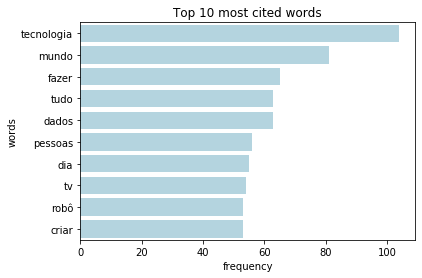


The search term (INTELIGÊNCIA ARTIFICIAL) has returned 1859 times.
The second term (TECNOLOGIA) has a frequency of 104.



In [11]:
# Applying function
words = most_words(df_tweets)

# Word frequencies and DataFrame
freq_all_words = FreqDist(words)
freq_df = pd.DataFrame(data=freq_all_words.most_common(
            11), columns=['words', 'frequency'])[1:]

# Plot Top 10 most cited words

sns.barplot(data=freq_df, x='frequency', y = 'words', color='lightblue')
plt.title('Top 10 most cited words')
plt.show()

print(f'\nThe search term ({TERM.upper()}) has returned {freq_all_words.most_common(1)[0][1]} times.')
print(f'The second term ({freq_all_words.most_common(2)[1][0].upper()}) has a frequency of {freq_all_words.most_common(2)[1][1]}.\n')

Now we are able to plot a **wordcloud**. It's include all tweet's words collected.

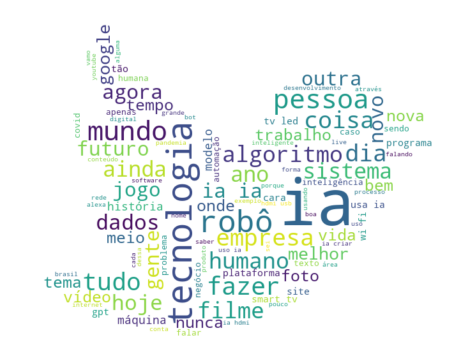

In [12]:
## Wordcloud Plot

# Figure shape
twitter_fig = np.array(Image.open("twitter_black.png"))

# Word list into string
words_str = ' '.join(words)

# Wordcloud
wordcloud = WordCloud(max_font_size=100, width=1520,
                      height=535, max_words=100,
                      mask=twitter_fig, background_color='white').generate(words_str)

# Image
plt.figure(figsize=(8, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

> **Q3. What were the @user accounts most cited in tweets?**

General code steps:
* Collect tweet text;
* Filter the @users;
* Count the number of frequency and plot the graph

In [13]:
def most_arroba(data):
    
    # collect text
    tweets = data['tweet_text']
    
    # collect only @users
    arroba = []
    for line in tweets:
        word_split = line.split()
        for word in word_split:
            if word.startswith("@"):
                arroba.append(word)

    # top 10 @users most cited
    top_10 = pd.DataFrame(arroba, columns=['count'])[
        'count'].value_counts().sort_values(ascending=False).head(10)

    return top_10

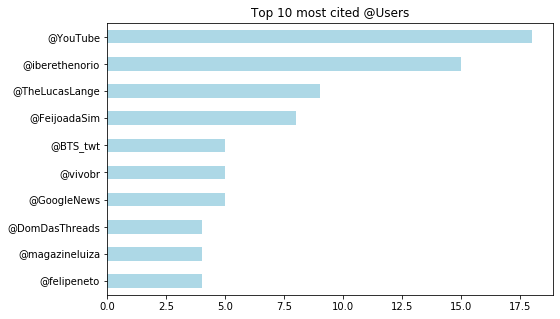

In [14]:
plt.figure(figsize=(8,5))
most_arroba(df_tweets).sort_values(ascending=True).plot.barh(color='lightblue')
plt.title('Top 10 most cited @Users', fontsize=12)
plt.show()

> **Q4. What were the most used #hashtags and their relationships?**

General code steps:
* Collect words from hashtags collumn;
* Calculate the word frequency distribution. Get the top 10;
* Select hashtag where the cell contains more than 2 hashtags, in order to find associations;
* Apply association rules;
* Plot the associations. *In case of graph does not appears, there is no associations*

In [15]:
def most_hashtag(df_tweets):
    
    # collect hashtags
    data = df_tweets.hashtags.apply(lambda x: np.nan if len(x) <= 1 else x)
    all_hashtags = list(data.dropna())

    hashtags = []
    for i in all_hashtags:
        for j in i:
            hashtags.append(j)

    hash_str = ''
    for i in hashtags:
        hash_str += i + ' '

        hash_str = hash_str.lower()
        hashtags2 = hash_str.split()
        
    # hashtags frequencies (top 10)
    freq = FreqDist(hashtags2)
    
    hash_most_freq = pd.DataFrame(data=freq.most_common(
        10), columns=['Hashtag', 'Frequency'])
    
    list_freq = list(hash_most_freq.Hashtag)

    all_hashtags_lower = [[h.lower() for h in line] for line in all_hashtags]
    
    # select hashtag where the cell contains more than 2 hashtags
    def select_hashtag(freq, all_hash):
        select = []

        for list_hash in all_hash:
            for f in freq:
                if (len(list_hash) >= 2 and (f in list_hash)):
                    select.append(list_hash)
                    break
                else:
                    pass
                
        return select

    select = select_hashtag(list_freq, all_hashtags_lower)

    # Apply association rules
    te = TransactionEncoder()
    te_ary = te.fit(select).transform(select)
    
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True)

    rules = association_rules(
        frequent_itemsets, metric="lift", min_threshold=1)

    return rules

C:\Users\paull\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


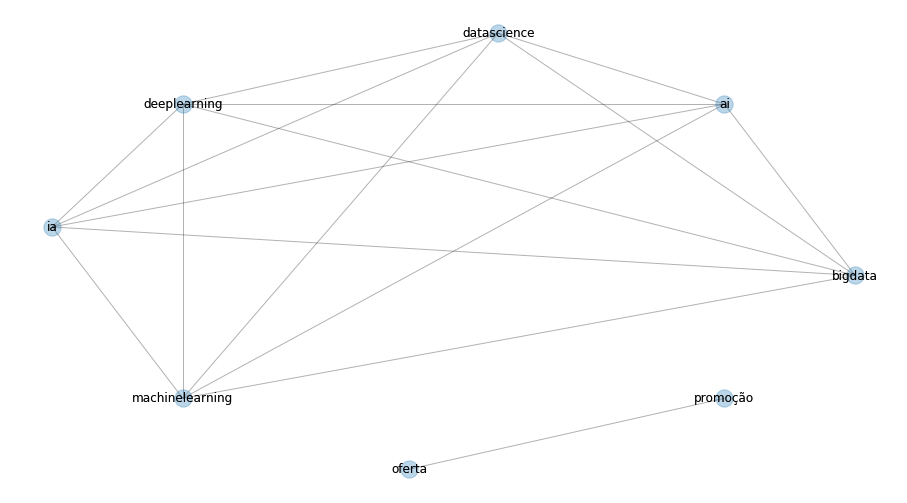

In [16]:
# Apply the function
rules = most_hashtag(df_tweets)

# If (antecedents) Then (consequents) association rules
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))


fig, ax = plt.subplots(figsize=(16, 9))
GA = nx.from_pandas_edgelist(
    rules, source='antecedents', target='consequents')
circPos=nx.circular_layout(GA)

pos_attrs = {}

for node, coords in circPos.items():
    pos_attrs[node] = (coords[0]+0.1*(-1)*np.sign(coords[0]),
                       coords[1]+0.1*(-1)*np.sign(coords[1]))

nx.draw(GA, with_labels=True, pos=pos_attrs, alpha=0.3)
nx.draw_networkx_labels(GA, pos_attrs, alpha=1)

fig.show()

That's it! We hope you have enjoied this analysis. Any suggestions we are totally opened the hear you!

> **You are now able to see your own search term accessing our app. Just [CLICK HERE](https://www.link.com).**

![allright](allright.jpg)
School photo created by <a href='https://www.freepik.com/photos/school'>drobotdean</a> - www.freepik.com